In [1]:
!git clone https://github.com/millermuttu/TSAI-EVA5.git
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

Cloning into 'TSAI-EVA5'...
remote: Enumerating objects: 324, done.
remote: Counting objects: 100% (324/324), done.
remote: Compressing objects: 100% (255/255), done.
remote: Total 324 (delta 139), reused 203 (delta 58), pack-reused 0
Receiving objects: 100% (324/324), 2.98 MiB | 1.53 MiB/s, done.
Resolving deltas: 100% (139/139), done.
     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 952kB 6.9MB/s 
albumentations==0.4.6 is successfully installed


In [2]:
cd /content/TSAI-EVA5/week10/

/content/TSAI-EVA5/week10


In [3]:
import torch
import dataset
import models
import utils
import visual
import gradcam
import numpy as np
from torchvision import transforms
from train_test import train, test
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
cuda, device = utils.misc.initialize_device(utils.config.SEED)

GPU Available? True


In [5]:
trainset = dataset.pytorch_datasets(True, True, dataset_name='cifar10')
testset = dataset.pytorch_datasets(False, True, dataset_name='cifar10')

Extracting /content/TSAI-EVA5/week10/dataset/cifar10/cifar-10-python.tar.gz to /content/TSAI-EVA5/week10/dataset/cifar10
Files already downloaded and verified


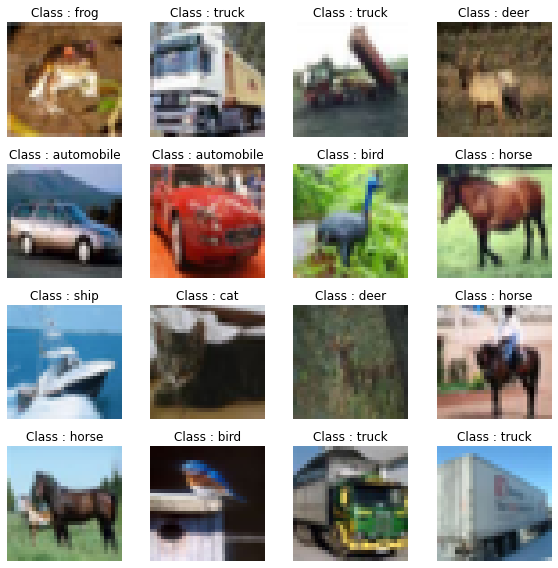

In [6]:
visual.visualization.show_imgs(trainset, 16, (8, 8))

In [7]:
mean, std = dataset.img_reg.get_stats(trainset)[0], dataset.img_reg.get_stats(trainset)[1]
print(mean, std)

(0.4914, 0.4822, 0.4465) (0.247, 0.2435, 0.2616)


In [8]:
transformations_list = [A.Normalize(mean, std)]
augmentations_list = [A.HorizontalFlip(), 
                      A.Rotate(limit=5),
                      A.Cutout(1, 8, 8, fill_value=mean, p=0.5),
                     ]

In [9]:
trainset = dataset.pytorch_datasets(True, True, transformations_list, augmentations_list, dataset_name='cifar10')
testset = dataset.pytorch_datasets(False, True, transformations_list, dataset_name='cifar10')
train_dl = dataset.data_loader(trainset, utils.config.BATCH_SIZE, utils.config.NUM_WORKERS, cuda, shuffle=True)
test_dl = dataset.data_loader(testset, utils.config.BATCH_SIZE, utils.config.NUM_WORKERS, cuda, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


/content/TSAI-EVA5/week10/visual/visualization.py:47: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


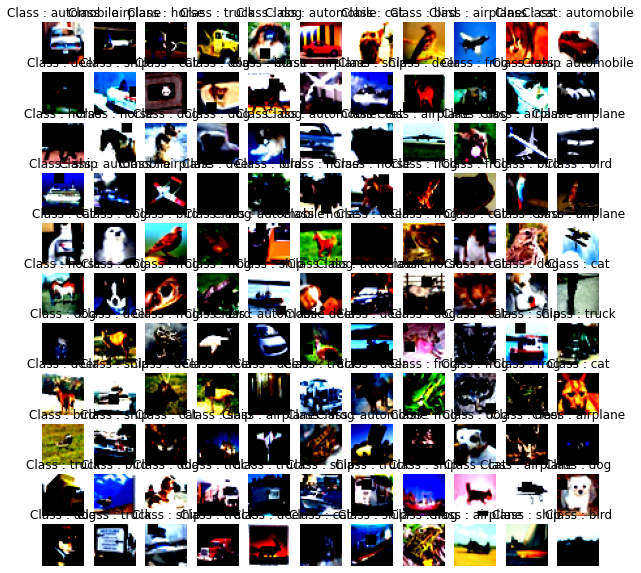

In [10]:
visual.visualization.show_batch(train_dl)

In [11]:
#Define model
model = models.ResNet18().to(device)

In [12]:
utils.misc.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [13]:
utils.config.EPOCHS

15

In [14]:
model = models.ResNet18().to(device)
loss_fn = utils.misc.cross_entropy_loss_fn()
optimizer = utils.misc.sgd_optimizer(model,lr=1e-4)

In [15]:
lr_finder = utils.lr_finder.LRFinder(model, optimizer, loss_fn, device=device)
lr_finder.range_test(train_dl, end_lr=100, num_iter=100)

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 1.75E+00


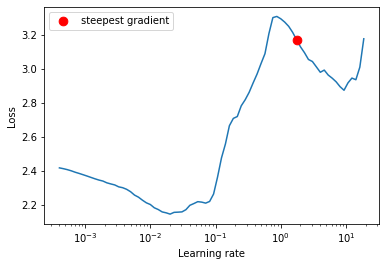

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6d08ed8c88>, 1.7475284000076838)

In [16]:
lr_finder.plot()

In [17]:
lr_finder.reset()

In [29]:
utils.config.EPOCHS = 25

In [30]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
model = models.ResNet18().to(device)
loss_fn = utils.misc.cross_entropy_loss_fn()
optimizer = utils.misc.sgd_optimizer(model,lr=0.1)
# scheduler = ReduceLROnPlateau(optimizer,'min',patience=5,verbose=True, min_lr=1e-3,cooldown=2)
# scheduler = ReduceLROnPlateau(optimizer,'min',patience=2,verbose=True, min_lr=1e-4)
scheduler = utils.misc.StepLR_scheduler(optimizer, step_size=6)
if utils.config.DEBUG == True:
    utils.config.EPOCHS = 15

test_loss = []
test_accuracy = []
train_losses = []
train_accuracy = []
misclassified_imgs = []
for epoch in range(utils.config.EPOCHS):
    print(f"Running Epoch {epoch+1}/{utils.config.EPOCHS}\n")
    train(model, train_dl, optimizer, loss_fn, device, train_losses, train_accuracy)
    tl = test(model, test_dl, loss_fn, device, 25, test_loss, test_accuracy, misclassified_imgs)
    scheduler.step(tl)

  0%|          | 0/391 [00:00<?, ?it/s]

Running Epoch 1/25



Loss=1.65 Batch_ID=390 Accuracy=35.39: 100%|██████████| 391/391 [00:29<00:00, 13.31it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0117, Accuracy: 4618/10000 (46.18%)

Running Epoch 2/25



  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0089, Accuracy: 5906/10000 (59.06%)

Running Epoch 3/25



  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0077, Accuracy: 6568/10000 (65.68%)

Running Epoch 4/25



  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0066, Accuracy: 7055/10000 (70.55%)

Running Epoch 5/25



  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0059, Accuracy: 7410/10000 (74.10%)

Running Epoch 6/25



  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0052, Accuracy: 7738/10000 (77.38%)

Running Epoch 7/25



  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 7904/10000 (79.04%)

Running Epoch 8/25



  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0044, Accuracy: 8055/10000 (80.55%)

Running Epoch 9/25



  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0042, Accuracy: 8213/10000 (82.13%)

Running Epoch 10/25



  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0041, Accuracy: 8247/10000 (82.47%)

Running Epoch 11/25



  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0039, Accuracy: 8409/10000 (84.09%)

Running Epoch 12/25



  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0041, Accuracy: 8333/10000 (83.33%)

Running Epoch 13/25



  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0038, Accuracy: 8514/10000 (85.14%)

Running Epoch 14/25



  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0041, Accuracy: 8439/10000 (84.39%)

Running Epoch 15/25



  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0043, Accuracy: 8428/10000 (84.28%)

Running Epoch 16/25



  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0040, Accuracy: 8490/10000 (84.90%)

Running Epoch 17/25



  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0038, Accuracy: 8613/10000 (86.13%)

Running Epoch 18/25



  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0039, Accuracy: 8585/10000 (85.85%)

Running Epoch 19/25



  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0040, Accuracy: 8635/10000 (86.35%)

Running Epoch 20/25



  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0040, Accuracy: 8610/10000 (86.10%)

Running Epoch 21/25



  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0045, Accuracy: 8605/10000 (86.05%)

Running Epoch 22/25



  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0041, Accuracy: 8621/10000 (86.21%)

Running Epoch 23/25



  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0044, Accuracy: 8580/10000 (85.80%)

Running Epoch 24/25



  0%|          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0048, Accuracy: 8569/10000 (85.69%)

Running Epoch 25/25



Loss=0.14 Batch_ID=390 Accuracy=97.48: 100%|██████████| 391/391 [00:29<00:00, 13.45it/s]



Validation set: Average loss: 0.0041, Accuracy: 8689/10000 (86.89%)



Mode set to GradCAM.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


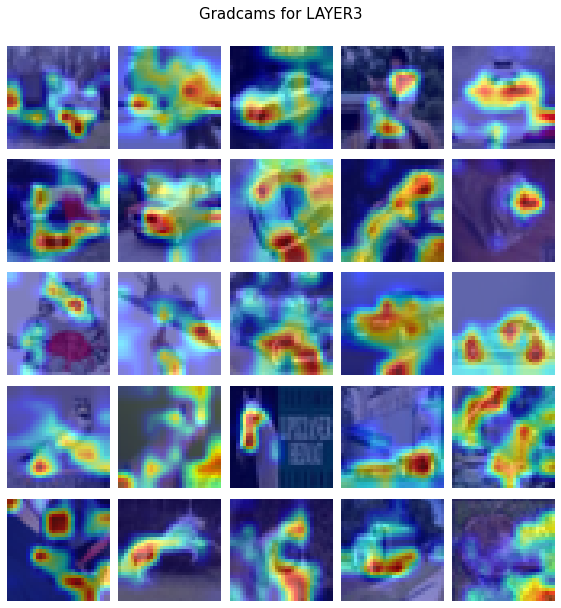

<Figure size 432x288 with 0 Axes>

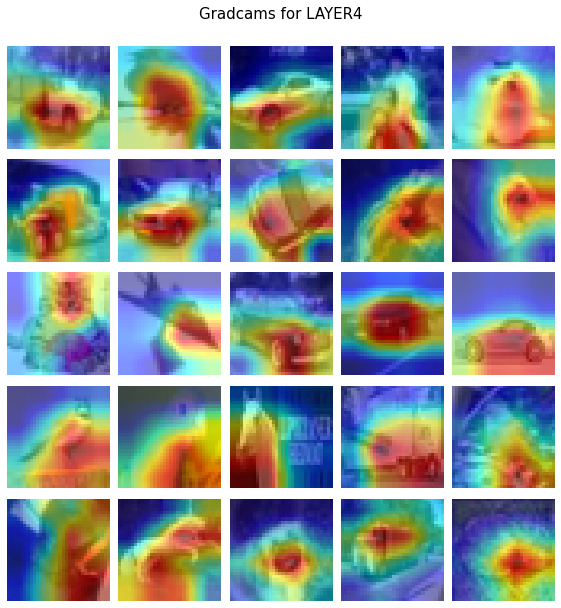

<Figure size 432x288 with 0 Axes>

In [31]:
grad_cam = gradcam.GradCAMView(model, ['layer3', 'layer4'],device, mean, std)
class_idx = trainset.class_to_idx
dataiter = iter(test_dl)
images, labels = dataiter.next()
image_list = images[:25]
grad_cam(image_list,class_idx, plot_size=(8,8))

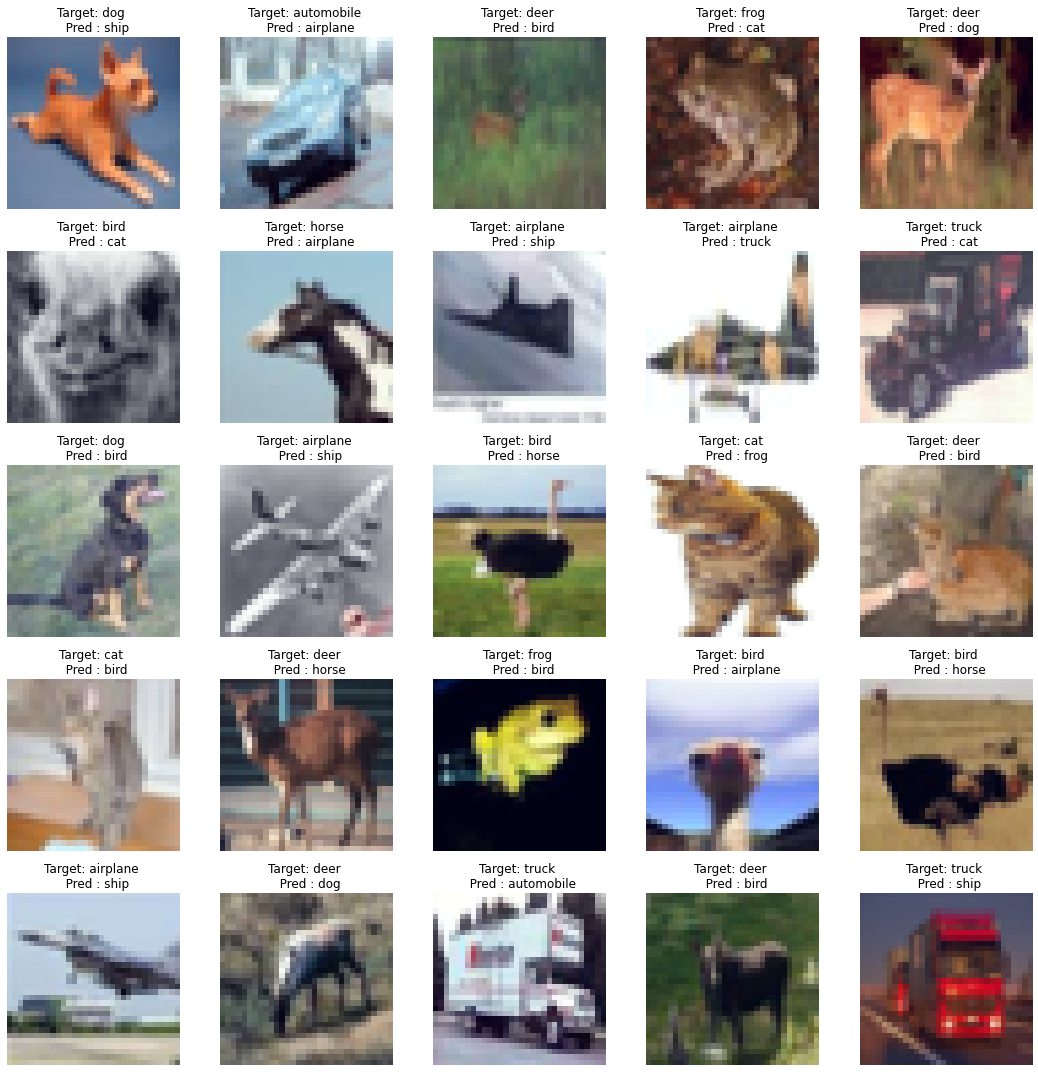

In [32]:
visual.plot_incorrect_images(misclassified_imgs,class_idx)

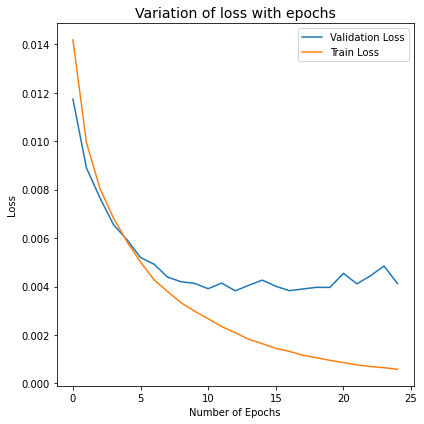

In [33]:
visual.plot_metrics([{'metric':test_loss, 'label':'Validation Loss'},
                    {'metric':train_losses, 'label':'Train Loss'}], "Loss")

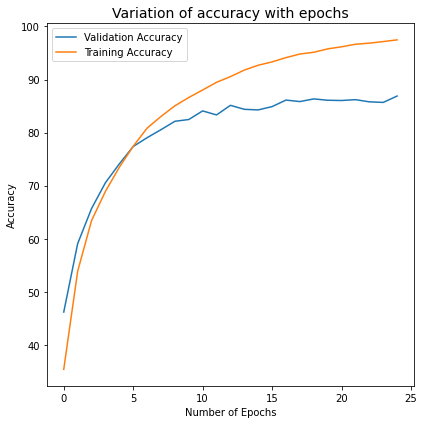

In [34]:
visual.plot_metrics([{'metric':test_accuracy, 'label':'Validation Accuracy'},
                    {'metric':train_accuracy, 'label':'Training Accuracy'}], "Accuracy")